# Price Forecasting of Egg Prices: A Time Series Analysis

- A project aimed to analyze the time series of egg prices by first detrending the data to remove any long-term trends, then deseasonalizing it to remove any seasonal cycles, and finally fitting an ARMA model to capture any remaining autocorrelation and moving average patterns in the data. 
- By doing so, we sought to gain insights into the cyclical patterns of egg prices and to develop a model that could be used to forecast future prices. The results of the analysis could be useful for stakeholders in the egg industry, such as producers, distributors, and consumers, in making informed decisions about pricing and supply chain management.

In [1]:
#Import the necessary Python packages

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA
from sklearn.metrics import mean_squared_error, r2_score
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load the data from the Excel file

data = pd.read_excel('Data.xls', usecols = ['TIME', 'Value'])
# data['TIME'] = pd.to_datetime(data['TIME'], format = '%Y-%m')
data

,TIME,Value
0,2000-01-01,0.975
1,2000-02-01,0.962
2,2000-03-01,0.931
3,2000-04-01,0.939
4,2000-05-01,0.852
...,...,...
274,2022-11-01,3.589
275,2022-12-01,4.250
276,2023-01-01,4.823
277,2023-02-01,4.211


### Getting the log Values of egg prices

In [3]:
data['log'] = np.log(data['Value'])
data.head()

,TIME,Value,log
0,2000-01-01,0.975,-0.025318
1,2000-02-01,0.962,-0.038741
2,2000-03-01,0.931,-0.071496
3,2000-04-01,0.939,-0.062940
4,2000-05-01,0.852,-0.160169


# Exploratory Data Analysis

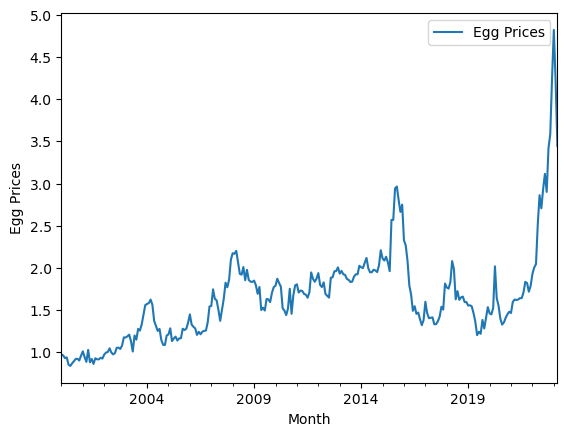

In [4]:
ax = data.plot(x='TIME', y='Value', label = 'Egg Prices')
_  = ax.legend()
_  = ax.set_xlabel('Month')
_  = ax.set_ylabel('Egg Prices')

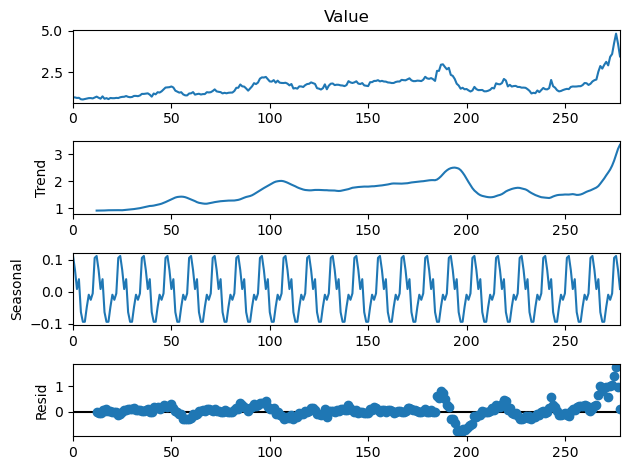

In [5]:
result = seasonal_decompose(data["Value"], period=12, two_sided = False)
fig = result.plot()
plt.show()

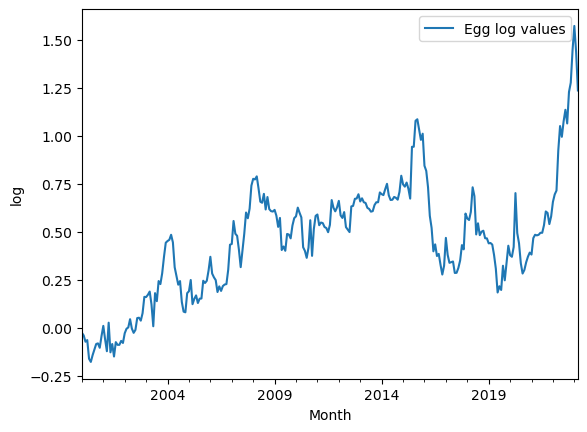

In [6]:
ax = data.plot(x='TIME', y='log', label = 'Egg log values')
_ = ax.legend()
_ = ax.set_xlabel('Month')
_ = ax.set_ylabel('log')

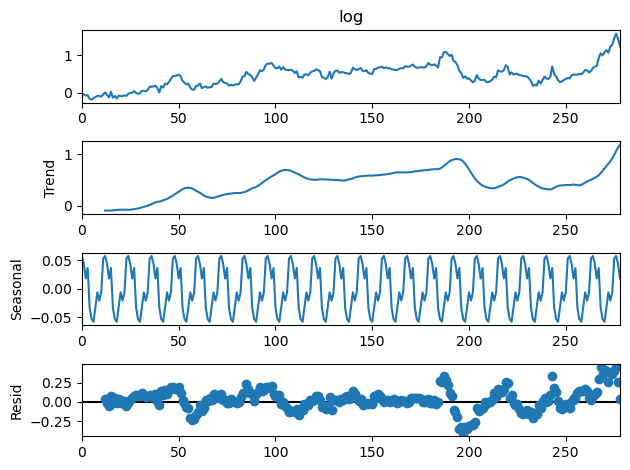

In [7]:
result = seasonal_decompose(data['log'], period=12, two_sided = False)
fig = result.plot()
plt.show()

In [8]:
data['Month'] = data.index
data.head()

,TIME,Value,log,Month
0,2000-01-01,0.975,-0.025318,0
1,2000-02-01,0.962,-0.038741,1
2,2000-03-01,0.931,-0.071496,2
3,2000-04-01,0.939,-0.062940,3
4,2000-05-01,0.852,-0.160169,4


In [9]:
# Function to check stationarity

def adf_test(data_set):
    print("Observations from Dickey-fuller test")
    dftest = adfuller(data_set.dropna())
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['critical value (%s)'%key]= value
    print(dfoutput)
    
    result = adfuller(data_set)
        
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.") 
    else:
        print("Weak evidence against null hypothesis. Time series is non-stationary.")

### Checking if value is stationary

In [10]:
#checking to see if data is stationary

adf_test(data['Value'])

Observations from Dickey-fuller test
Test Statistic                  -1.618731
p-value                          0.473394
#lags used                       1.000000
number of observations used    277.000000
critical value (1%)             -3.454180
critical value (5%)             -2.872031
critical value (10%)            -2.572360
dtype: float64
Weak evidence against null hypothesis. Time series is non-stationary.


### Checking if Log values are stationary

In [11]:
adf_test(data['log'])

Observations from Dickey-fuller test
Test Statistic                  -1.444935
p-value                          0.560554
#lags used                       0.000000
number of observations used    278.000000
critical value (1%)             -3.454094
critical value (5%)             -2.871993
critical value (10%)            -2.572340
dtype: float64
Weak evidence against null hypothesis. Time series is non-stationary.


## Train-Test split

In [12]:
#Split Data into Test and Train

total_size = data.shape[0]
train_size = int(total_size*0.8)

data_train = data.iloc[:train_size]
data_test  = data.iloc[train_size:]

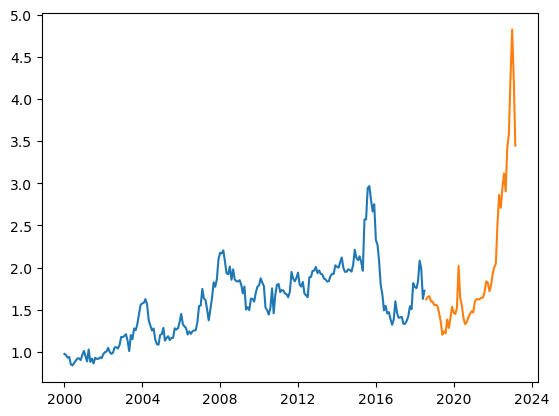

In [13]:
 #Plot Test and Train Data: Value

plt.plot(data_train['TIME'], data_train['Value'])
plt.plot(data_test['TIME'], data_test['Value'])
plt.show()

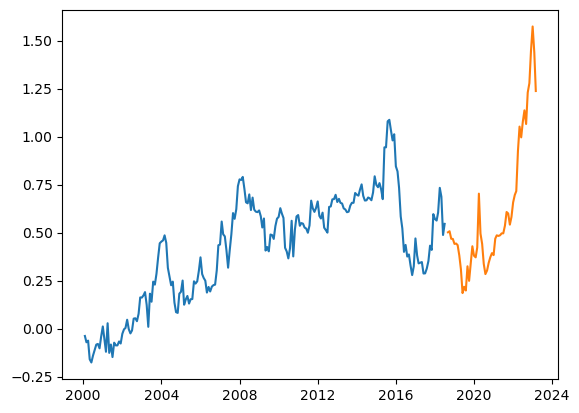

In [14]:
 #Plot Test and Train Data: log change

plt.plot(data_train['TIME'][1:], data_train['log'][1:])
plt.plot(data_test['TIME'][1:], data_test['log'][1:])
plt.show()

# Removing Trend and Seasonality

## Detrending Method 1: Linear Trend

### Removing Trend

Original Values

In [15]:
lr = LinearRegression(fit_intercept = True)
_ = lr.fit(data_train[['Month']],data_train['Value'])

In [16]:
print("slope: {}".format(round(lr.coef_[0],5)))
print("intercept: {}".format(round(lr.intercept_,5)))

slope: 0.00484
intercept: 1.03348


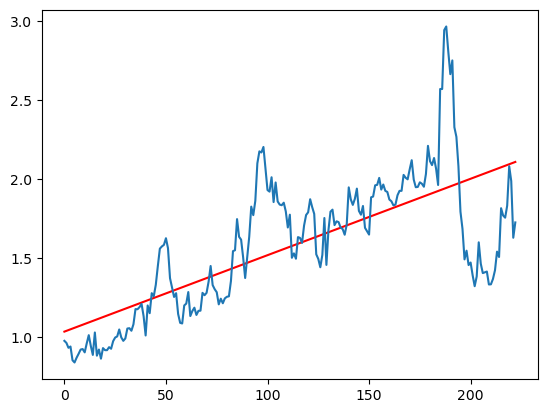

In [17]:
_ = plt.plot(data_train[['Month']], lr.predict(data_train[['Month']]), color = "red")
_ = plt.plot(data_train['Value'])

In [18]:
data_train['detrend'] = data_train['Value'] - data_train['Month'] * lr.coef_[0] - lr.intercept_

Log-Values

In [19]:
lr_log = LinearRegression(fit_intercept = True)
_ = lr_log.fit(data_train[['Month']][1:],data_train['log'][1:])

In [20]:
print("slope: {}".format(round(lr_log.coef_[0], 5)))
print("intercept: {}".format(round(lr_log.intercept_, 5)))

slope: 0.00332
intercept: 0.04436


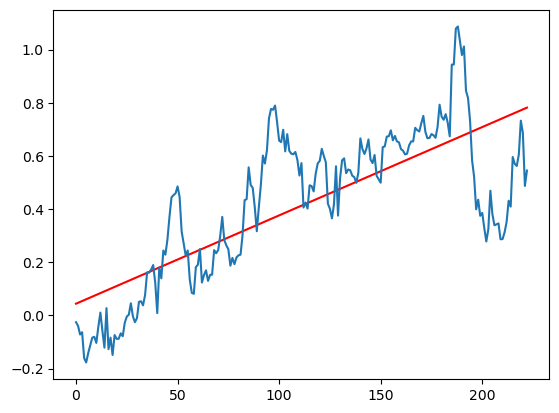

In [21]:
_ = plt.plot(data_train[['Month']], lr_log.predict(data_train[['Month']]), color = "red")
_ = plt.plot(data_train['log'])

In [22]:
data_train['detrend_log'] = data_train['log'] - data_train['Month'] * lr_log.coef_[0] - lr_log.intercept_

In [23]:
data_train.head()

,TIME,Value,log,Month,detrend,detrend_log
0,2000-01-01,0.975,-0.025318,0,-0.058483,-0.069679
1,2000-02-01,0.962,-0.038741,1,-0.076323,-0.086424
2,2000-03-01,0.931,-0.071496,2,-0.112164,-0.122501
3,2000-04-01,0.939,-0.062940,3,-0.109004,-0.117267
4,2000-05-01,0.852,-0.160169,4,-0.200844,-0.217818


### Removing Seasonality

In [24]:
def seasonal_mean(data, freq=12):
  data = data.dropna()
  averages = np.zeros(shape=freq)
  count = np.zeros(shape=freq)
  for i in range(len(data)):
    averages[i % freq] += data.iloc[i]
    count[i % freq] += 1
  averages = (averages / count)
  seasonal = [ averages[i % freq] for i in range(len(data)) ]
  return averages

Seasonality of the value columns

In [25]:
seasonality_1 = seasonal_mean(data_train['detrend'])

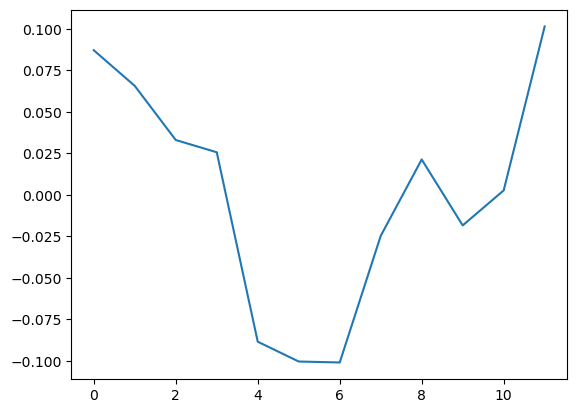

In [26]:
_ = plt.plot(range(0,12), seasonality_1)

In [27]:
round(sum(seasonality_1),3)

0.004

In [28]:
seasonal_train_1 = [ seasonality_1[i%12] for i in range(len(data_train)) ]
data_train['residual'] = data_train['detrend'] - pd.Series(seasonal_train_1, index=data_train.index)

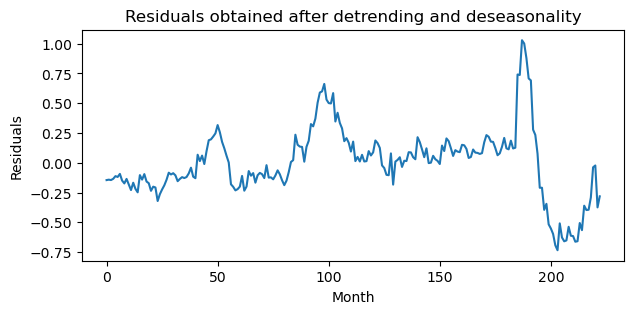

In [29]:
plt.figure(figsize=(7, 3))
# create a line plot with title, x-axis label, and y-axis label
plt.plot(data_train['Month'], data_train['residual'])
plt.title('Residuals obtained after detrending and deseasonality')
plt.xlabel('Month')
plt.ylabel('Residuals')
plt.show()

Seasonality of log values

In [30]:
seasonality_2 = seasonal_mean(data_train['log'])

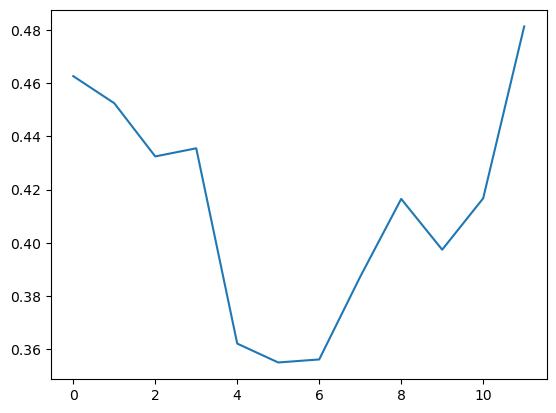

In [31]:
_ = plt.plot(range(0,12), seasonality_2)

In [32]:
round(sum(seasonality_2),3)

4.955

In [33]:
seasonal_train_2 = [ seasonality_2[i%12] for i in range(len(data_train)) ]
data_train['residual_log'] = data_train['detrend_log'] - pd.Series(seasonal_train_2, index=data_train.index)

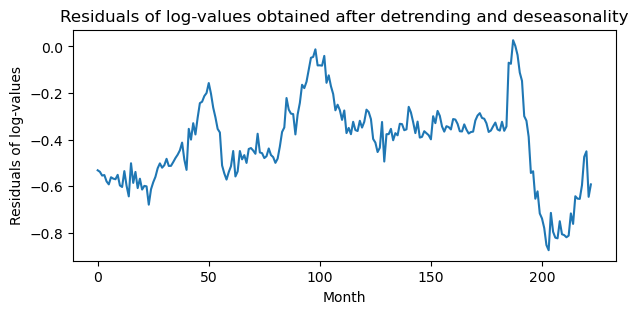

In [34]:
plt.figure(figsize=(7, 3))
# create a line plot with title, x-axis label, and y-axis label
plt.plot(data_train['Month'], data_train['residual_log'])
plt.title('Residuals of log-values obtained after detrending and deseasonality')
plt.xlabel('Month')
plt.ylabel('Residuals of log-values')
plt.show()

### Stationarity Test

In [35]:
adf_test(data_train['residual'])

Observations from Dickey-fuller test
Test Statistic                  -3.422920
p-value                          0.010202
#lags used                       4.000000
number of observations used    218.000000
critical value (1%)             -3.460708
critical value (5%)             -2.874891
critical value (10%)            -2.573886
dtype: float64
Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.


In [36]:
adf_test(data_train['residual_log'][1:])

Observations from Dickey-fuller test
Test Statistic                  -2.882386
p-value                          0.047435
#lags used                       4.000000
number of observations used    217.000000
critical value (1%)             -3.460849
critical value (5%)             -2.874953
critical value (10%)            -2.573919
dtype: float64
Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.


Based on the outcome of the ADF test, it is evident that the residual series is stationary, which allows us to utilize an ARMA model for it.

## Detrending Method 2: Moving Average

### Removing Trend

In [37]:
def detrend(ts, w):
    detrended = [np.nan]*(w-1)
    for i in range(w, len(ts)+1):
        trend = sum(ts[i-w:i])/w
        detrended.append(ts[i-1] - trend)
    return detrended

In [38]:
train_set_detrend_ma = data_train.iloc[0: , :]
train_set_detrend_ma

,TIME,Value,log,Month,detrend,detrend_log,residual,residual_log
0,2000-01-01,0.975,-0.025318,0,-0.058483,-0.069679,-0.145658,-0.532242
1,2000-02-01,0.962,-0.038741,1,-0.076323,-0.086424,-0.142027,-0.538831
2,2000-03-01,0.931,-0.071496,2,-0.112164,-0.122501,-0.145237,-0.554929
3,2000-04-01,0.939,-0.062940,3,-0.109004,-0.117267,-0.134711,-0.552750
4,2000-05-01,0.852,-0.160169,4,-0.200844,-0.217818,-0.112395,-0.579995
...,...,...,...,...,...,...,...,...
218,2018-03-01,1.831,0.604862,218,-0.257689,-0.163719,-0.290763,-0.596147
219,2018-04-01,2.081,0.732849,219,-0.012530,-0.039055,-0.038237,-0.474538
220,2018-05-01,1.987,0.686626,220,-0.111370,-0.088599,-0.022921,-0.450777
221,2018-06-01,1.628,0.487352,221,-0.475210,-0.291195,-0.374816,-0.646287


In [39]:
train_set_detrend_ma['detrend_MA'] = detrend(data_train['Value'], 4)
train_set_detrend_ma['detrend_log_MA'] = detrend(data_train['log'], 4)
train_set_detrend_ma = train_set_detrend_ma.dropna()
train_set_detrend_ma

,TIME,Value,log,Month,detrend,detrend_log,residual,residual_log,detrend_MA,detrend_log_MA
3,2000-04-01,0.939,-0.062940,3,-0.109004,-0.117267,-0.134711,-0.552750,-0.01275,-0.013316
4,2000-05-01,0.852,-0.160169,4,-0.200844,-0.217818,-0.112395,-0.579995,-0.06900,-0.076832
5,2000-06-01,0.838,-0.176737,5,-0.219685,-0.237708,-0.119290,-0.592800,-0.05200,-0.058902
6,2000-07-01,0.868,-0.141564,6,-0.194525,-0.205857,-0.093553,-0.562090,-0.00625,-0.006211
7,2000-08-01,0.893,-0.113169,7,-0.174366,-0.180784,-0.149668,-0.568051,0.03025,0.034741
...,...,...,...,...,...,...,...,...,...,...
218,2018-03-01,1.831,0.604862,218,-0.257689,-0.163719,-0.290763,-0.596147,0.03850,0.021405
219,2018-04-01,2.081,0.732849,219,-0.012530,-0.039055,-0.038237,-0.474538,0.22200,0.115200
220,2018-05-01,1.987,0.686626,220,-0.111370,-0.088599,-0.022921,-0.450777,0.07350,0.039925
221,2018-06-01,1.628,0.487352,221,-0.475210,-0.291195,-0.374816,-0.646287,-0.25375,-0.140570


### Removing Seasonality

In [40]:
seasonality_3 = seasonal_mean(train_set_detrend_ma['detrend_MA'])
seasonality_4 = seasonal_mean(train_set_detrend_ma['detrend_log_MA'])

In [41]:
seasonal_train_3 = [ seasonality_3[i % 12] for i in range(len(train_set_detrend_ma)) ]
train_set_detrend_ma['residuals_MA'] = train_set_detrend_ma['detrend_MA'] - pd.Series(seasonal_train_3, index=train_set_detrend_ma.index)

In [42]:
seasonal_train_4 = [ seasonality_4[i % 12] for i in range(len(train_set_detrend_ma)) ]
train_set_detrend_ma['residuals_log_MA'] = train_set_detrend_ma['detrend_log_MA'] - pd.Series(seasonal_train_4, index=train_set_detrend_ma.index)

In [43]:
train_set_detrend_ma['trend_MA'] = train_set_detrend_ma['Value'] - train_set_detrend_ma['detrend_MA']
train_set_detrend_ma.head()

,TIME,Value,log,Month,detrend,detrend_log,residual,residual_log,detrend_MA,detrend_log_MA,residuals_MA,residuals_log_MA,trend_MA
3,2000-04-01,0.939,-0.062940,3,-0.109004,-0.117267,-0.134711,-0.552750,-0.01275,-0.013316,0.007197,-0.003079,0.95175
4,2000-05-01,0.852,-0.160169,4,-0.200844,-0.217818,-0.112395,-0.579995,-0.06900,-0.076832,0.021197,-0.018386,0.92100
5,2000-06-01,0.838,-0.176737,5,-0.219685,-0.237708,-0.119290,-0.592800,-0.05200,-0.058902,0.008618,-0.017698,0.89000
6,2000-07-01,0.868,-0.141564,6,-0.194525,-0.205857,-0.093553,-0.562090,-0.00625,-0.006211,0.021434,0.014802,0.87425
7,2000-08-01,0.893,-0.113169,7,-0.174366,-0.180784,-0.149668,-0.568051,0.03025,0.034741,-0.021500,0.003698,0.86275


In [44]:
train_set_detrend_ma['trend_log_MA'] = train_set_detrend_ma['log'] - train_set_detrend_ma['detrend_log_MA']
train_set_detrend_ma.head()

,TIME,Value,log,Month,detrend,detrend_log,residual,residual_log,detrend_MA,detrend_log_MA,residuals_MA,residuals_log_MA,trend_MA,trend_log_MA
3,2000-04-01,0.939,-0.062940,3,-0.109004,-0.117267,-0.134711,-0.552750,-0.01275,-0.013316,0.007197,-0.003079,0.95175,-0.049624
4,2000-05-01,0.852,-0.160169,4,-0.200844,-0.217818,-0.112395,-0.579995,-0.06900,-0.076832,0.021197,-0.018386,0.92100,-0.083336
5,2000-06-01,0.838,-0.176737,5,-0.219685,-0.237708,-0.119290,-0.592800,-0.05200,-0.058902,0.008618,-0.017698,0.89000,-0.117835
6,2000-07-01,0.868,-0.141564,6,-0.194525,-0.205857,-0.093553,-0.562090,-0.00625,-0.006211,0.021434,0.014802,0.87425,-0.135352
7,2000-08-01,0.893,-0.113169,7,-0.174366,-0.180784,-0.149668,-0.568051,0.03025,0.034741,-0.021500,0.003698,0.86275,-0.147910


#### Analysis for original values

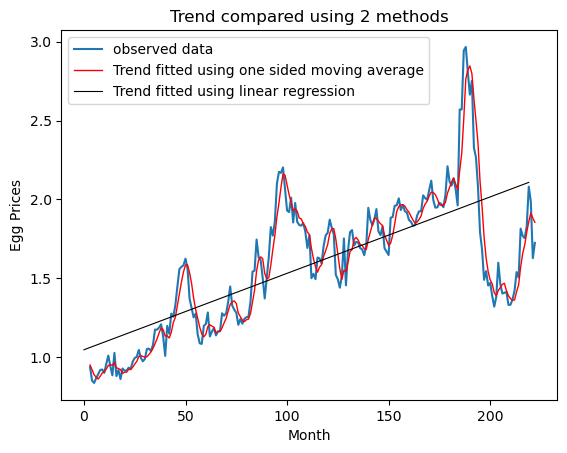

In [45]:
plt.plot(train_set_detrend_ma['Value'],label='observed data')
plt.plot(train_set_detrend_ma[['Month']], train_set_detrend_ma[['trend_MA']], label='Trend fitted using one sided moving average', color = "red", linewidth = 1)
plt.plot(lr.predict(train_set_detrend_ma[['Month']]),label='Trend fitted using linear regression', color = "black", linewidth = 0.8)
plt.xlabel('Month')
plt.ylabel('Egg Prices')
plt.title('Trend compared using 2 methods')
_ = plt.legend()

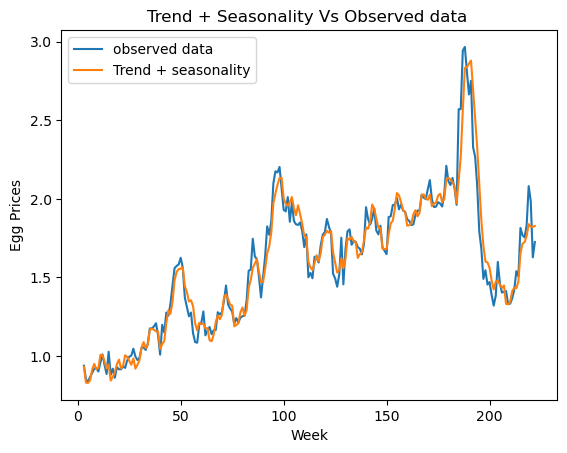

In [46]:
train_set_detrend_ma['trend_plus_seasonality'] = train_set_detrend_ma['trend_MA'] + pd.Series(seasonal_train_3, index = train_set_detrend_ma.index)

plt.plot(train_set_detrend_ma['Value'], label='observed data')
plt.plot(train_set_detrend_ma[['Month']], train_set_detrend_ma['trend_plus_seasonality'], label='Trend + seasonality')
plt.xlabel('Week')
plt.ylabel('Egg Prices')
plt.title('Trend + Seasonality Vs Observed data ')
_ = plt.legend()

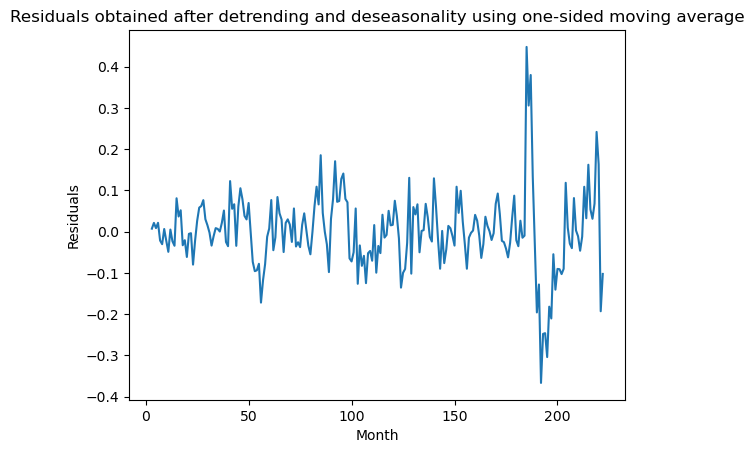

In [47]:
plt.plot(train_set_detrend_ma['Month'], train_set_detrend_ma['residuals_MA'], '-')
plt.title('Residuals obtained after detrending and deseasonality using one-sided moving average')
plt.xlabel('Month')
plt.ylabel('Residuals')
plt.show()

In [48]:
adf_test(train_set_detrend_ma['residuals_MA'].dropna())

Observations from Dickey-fuller test
Test Statistic                -6.263867e+00
p-value                        4.159676e-08
#lags used                     2.000000e+00
number of observations used    2.170000e+02
critical value (1%)           -3.460849e+00
critical value (5%)           -2.874953e+00
critical value (10%)          -2.573919e+00
dtype: float64
Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.


#### Analysis on log-values

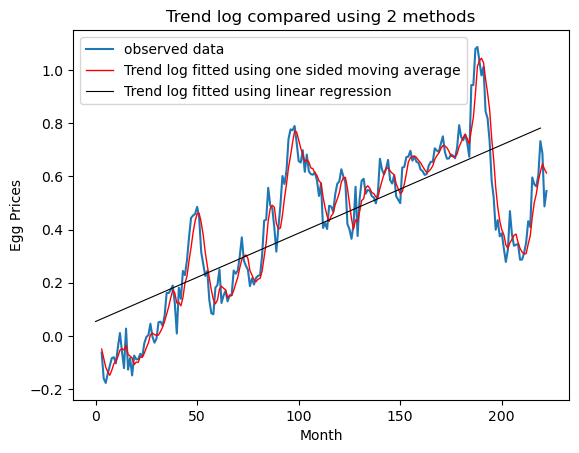

In [49]:
plt.plot(train_set_detrend_ma['log'],label='observed data')
plt.plot(train_set_detrend_ma[['Month']], train_set_detrend_ma[['trend_log_MA']], label='Trend log fitted using one sided moving average', color = "red", linewidth = 1)
plt.plot(lr_log.predict(train_set_detrend_ma[['Month']]),label='Trend log fitted using linear regression', color = "black", linewidth = 0.8)
plt.xlabel('Month')
plt.ylabel('Egg Prices')
plt.title('Trend log compared using 2 methods')
_ = plt.legend()

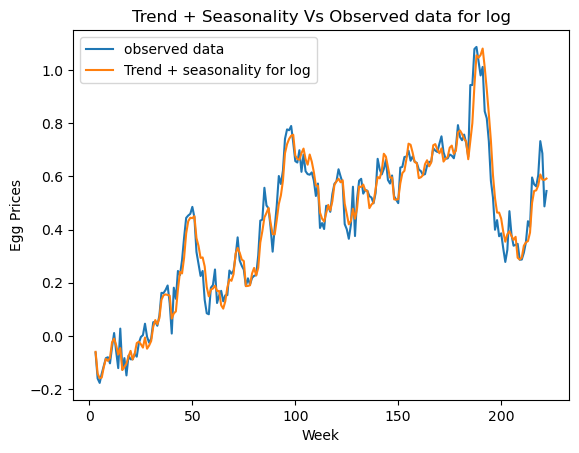

In [50]:
train_set_detrend_ma['tend_plus_seasonality_log']  = train_set_detrend_ma['trend_log_MA'] 
train_set_detrend_ma['tend_plus_seasonality_log'] += pd.Series(seasonal_train_4, index = train_set_detrend_ma.index)

plt.plot(train_set_detrend_ma['log'], label='observed data')
plt.plot(train_set_detrend_ma[['Month']], train_set_detrend_ma['tend_plus_seasonality_log'], label='Trend + seasonality for log')
plt.xlabel('Week')
plt.ylabel('Egg Prices')
plt.title('Trend + Seasonality Vs Observed data for log')
plt.legend()

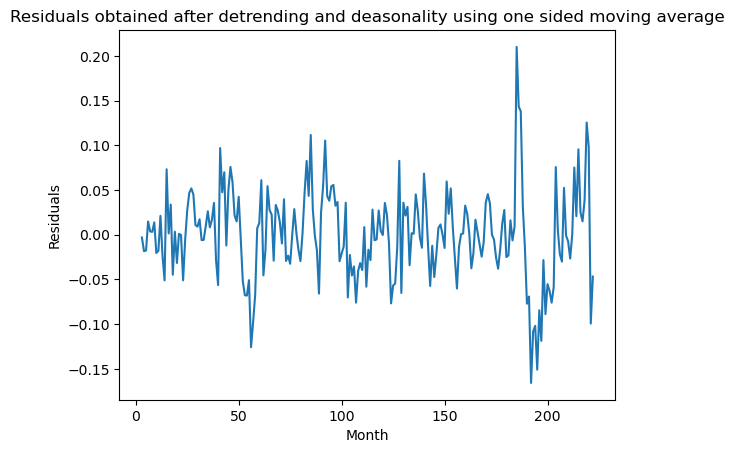

In [51]:
plt.plot(train_set_detrend_ma['Month'], train_set_detrend_ma['residuals_log_MA'], '-')
plt.title('Residuals obtained after detrending and deasonality using one sided moving average')
plt.xlabel('Month')
plt.ylabel('Residuals')
plt.show()

In [52]:
adf_test(train_set_detrend_ma['residuals_log_MA'].dropna())

Observations from Dickey-fuller test
Test Statistic                -8.217934e+00
p-value                        6.547022e-13
#lags used                     0.000000e+00
number of observations used    2.190000e+02
critical value (1%)           -3.460567e+00
critical value (5%)           -2.874830e+00
critical value (10%)          -2.573853e+00
dtype: float64
Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.


---

# Fitting ARMA Model

## Using Residuals from Detrending Method 1 (Linear Trend)

### Original Values

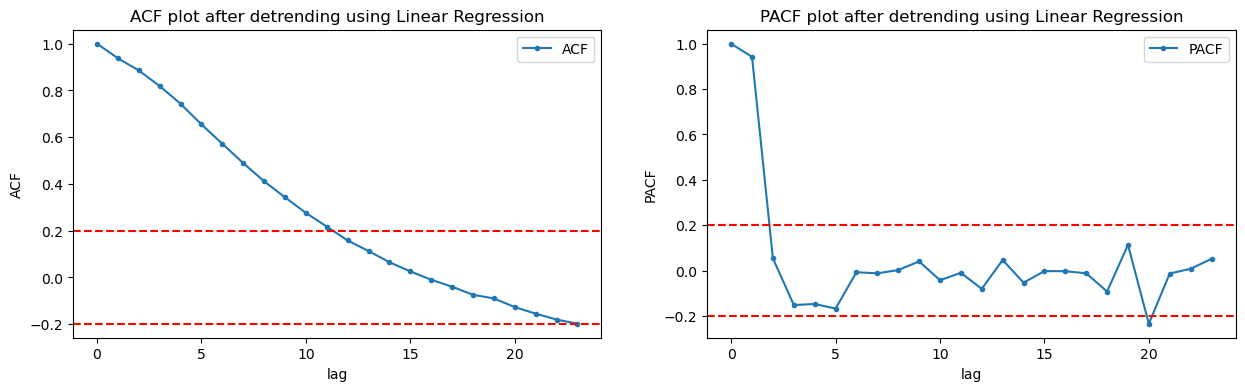

In [53]:
threshold = 0.2
ACF = acf(data_train['residual'])
PACF = pacf(data_train['residual'])

plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
plt.plot(ACF,'.-',label='ACF')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axhline(y=-threshold, color='r', linestyle='--')
plt.xlabel('lag')
plt.ylabel('ACF')
plt.title('ACF plot after detrending using Linear Regression')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(PACF,'.-',label='PACF')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axhline(y=-threshold, color='r', linestyle='--')
plt.xlabel('lag')
plt.ylabel('PACF')
plt.title('PACF plot after detrending using Linear Regression')
plt.legend()

- Now that we have our ACF and PACF graphs we can deduce the orders of the AR and MA for the model according to the values for the various lags.<br>
- Used to decide the AR order: PACF <br>
We see that the first lag exceed the 2 dotted horizontal lines. <br>
- Used to decide the MA order: ACF<br>
Only the first 11 lags have a value exceeding the 2 dotted horizontal lines. <br>

Therefore, the ARMA order will be (1, 11)<br>

In [54]:
arima_model_1_11 = ARIMA(data_train['residual'], order=(1,0,11))
model_1_11 = arima_model_1_11.fit()

#### For the purposes of understanding the working better first let us simply predict the in sample data. i.e. without adding the seasonality and the residuals

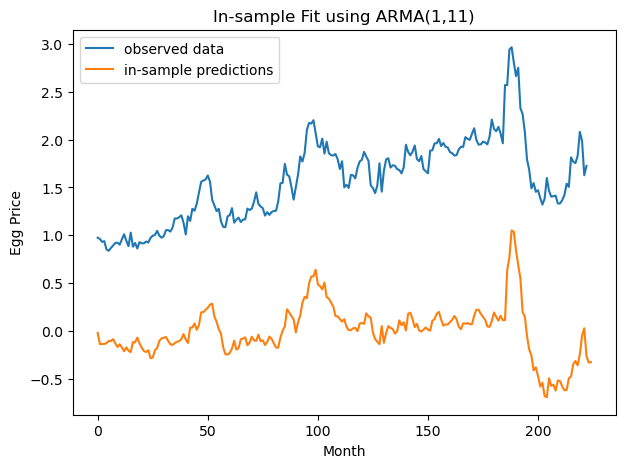

In [55]:
predictions = model_1_11.predict(start = 0, end = len(data_train)+1) 
plt.figure(figsize=(7,5))
plt.plot(data_train['Value'], label='observed data')
plt.plot(predictions, label='in-sample predictions')
plt.xlabel('Month')
plt.ylabel('Egg Price')
plt.title('In-sample Fit using ARMA(1,11)')
plt.legend()

Thus, we see that the predictions imitate the observed data but there is constant difference between the 2 data. <br>
#### Thus, next we add the seasonality and trend

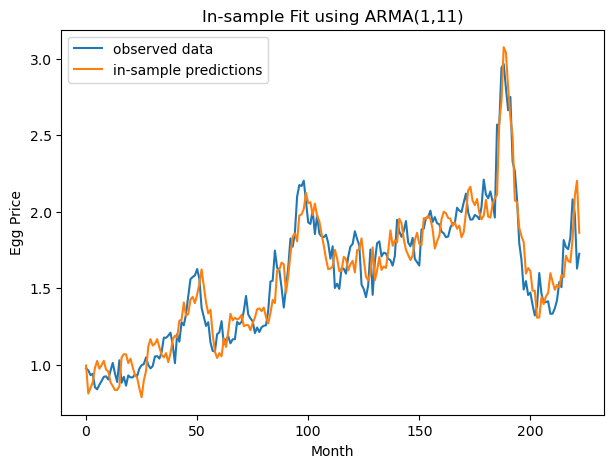

In [56]:
predictions = model_1_11.predict(start = 0, end = len(data_train)+1) + pd.Series([seasonal_train_3[t % 12] for t in data_train['Month']], index = data_train.index) + data_train['Month'] * lr.coef_[0] + lr.intercept_
plt.figure(figsize=(7,5))
plt.plot(data_train['Value'], label='observed data')
plt.plot(predictions, label='in-sample predictions')
plt.xlabel('Month')
plt.ylabel('Egg Price')
plt.title('In-sample Fit using ARMA(1,11)')
plt.legend()

### Fitting ARMA on log data

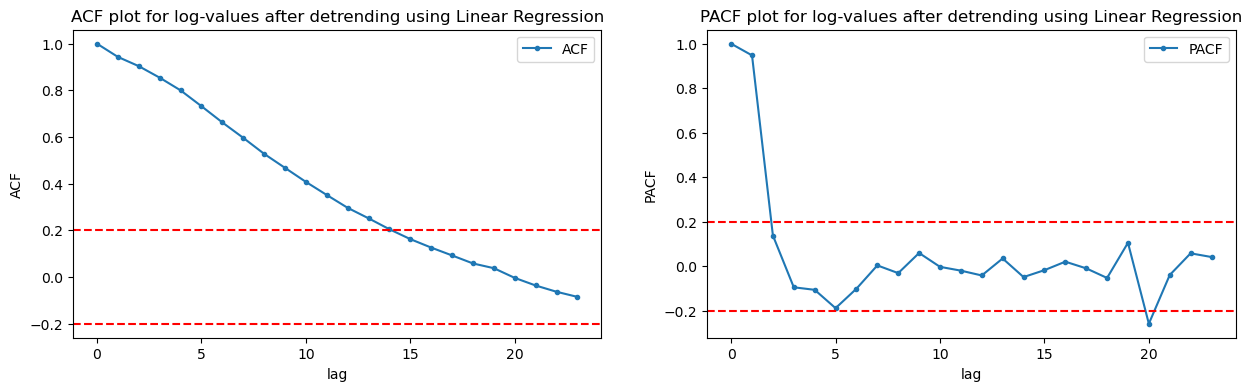

In [61]:
threshold = 0.2
ACF = acf(data_train['residual_log'])
PACF = pacf(data_train['residual_log'])

plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
plt.plot(ACF,'.-',label='ACF')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axhline(y=-threshold, color='r', linestyle='--')
plt.xlabel('lag')
plt.ylabel('ACF')
plt.title('ACF plot for log-values after detrending using Linear Regression')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(PACF,'.-',label='PACF')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axhline(y=-threshold, color='r', linestyle='--')
plt.xlabel('lag')
plt.ylabel('PACF')
plt.title('PACF plot for log-values after detrending using Linear Regression')
plt.legend()

In [58]:
arima_model_1_13 = ARIMA(data_train['residual'], order=(1,0,13))
model_1_13 = arima_model_1_13.fit()

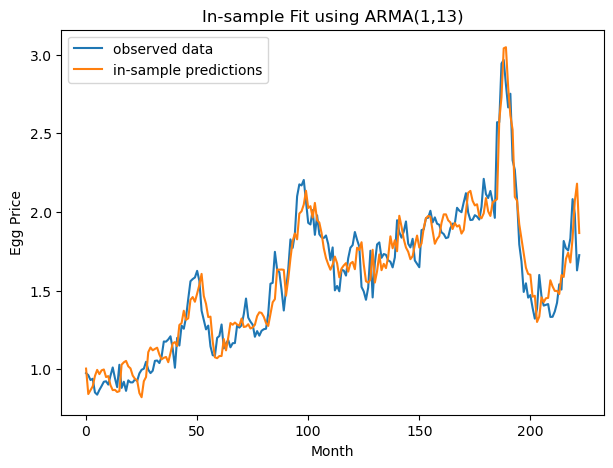

In [60]:
predictions = model_1_13.predict(start = 0, end = len(data_train)+1) + pd.Series([seasonal_train_4[t % 12] for t in data_train['Month']], index = data_train.index) + data_train['Month'] * lr.coef_[0] + lr.intercept_
plt.figure(figsize=(7,5))
plt.plot(data_train['Value'], label='observed data')
plt.plot(predictions, label='in-sample predictions')
plt.xlabel('Month')
plt.ylabel('Egg Price')
plt.title('In-sample Fit using ARMA(1,13)')
plt.legend()

## Using residuals from Detrending Method 2 (Moving Average)

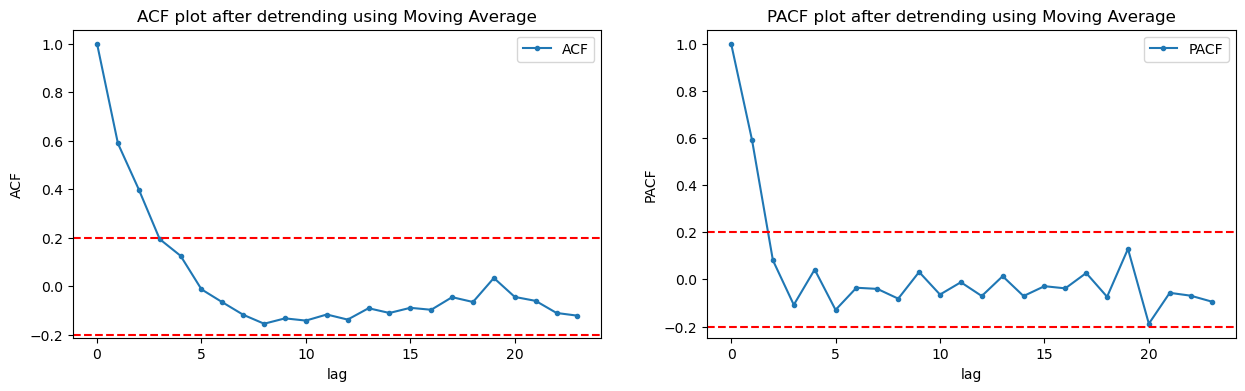

In [63]:
threshold = 0.2
ACF = acf(train_set_detrend_ma['residuals_MA'].dropna())
PACF = pacf(train_set_detrend_ma['residuals_MA'].dropna())

plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
plt.plot(ACF,'.-',label='ACF')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axhline(y=-threshold, color='r', linestyle='--')
plt.xlabel('lag')
plt.ylabel('ACF')
plt.title('ACF plot after detrending using Moving Average')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(PACF,'.-',label='PACF')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axhline(y=-threshold, color='r', linestyle='--')
plt.xlabel('lag')
plt.ylabel('PACF')
plt.title('PACF plot after detrending using Moving Average')
_ = plt.legend()

In [64]:
MA_arima_model_1_2 = ARIMA(train_set_detrend_ma['residuals_MA'].dropna(), order=(1,0,2))
model_1_2 = MA_arima_model_1_2.fit()

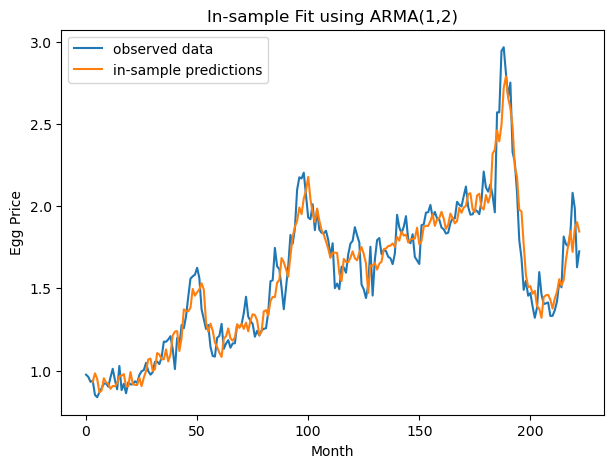

In [68]:
predictions  = pd.Series(model_1_2.predict(start = 0, end = len(data_train)), index = data_train.index)
predictions += pd.Series([np.nan]*3+[sum(data_train['Value'][i-4:i])/4 for i in range(4, int(len(data_train))+1)], index = data_train.index)
predictions += pd.Series([seasonality_3[t % 12] for t in data_train['Month']], index = data_train.index) 

plt.figure(figsize=(7,5))
plt.plot(data_train['Value'], label='observed data')
plt.plot(predictions, label='in-sample predictions')
plt.xlabel('Month')
plt.ylabel('Egg Price')
plt.title('In-sample Fit using ARMA(1,2)')
_ = plt.legend()

---

# Forecasting the Data

### Original Values

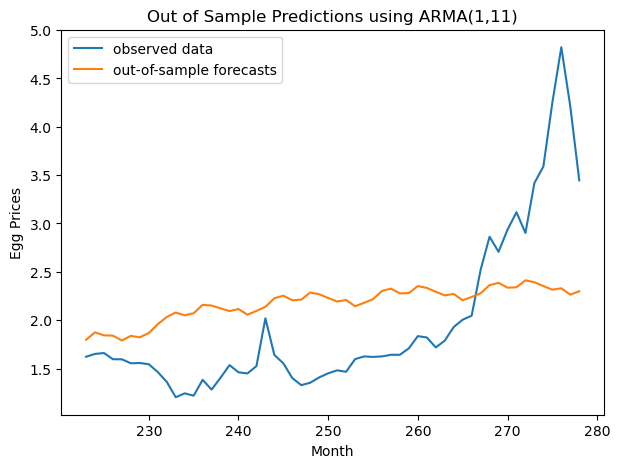

In [69]:
forecasts_1_11 = model_1_11.forecast(steps = len(data_test)) + pd.Series([seasonality_3[t % 12] for t in data_test['Month']], index = data_test.index) + data_test['Month'] * lr.coef_[0] + lr.intercept_
plt.figure(figsize=(7, 5))
plt.plot(data_test['Value'], label='observed data')
plt.plot(forecasts_1_11, label='out-of-sample forecasts')
plt.xlabel('Month')
plt.ylabel('Egg Prices')
plt.title('Out of Sample Predictions using ARMA(1,11)')
_ = plt.legend()

In [70]:
round(mean_squared_error(data_test['Value'], forecasts_1_11), 5)

0.63079

### Log-Values

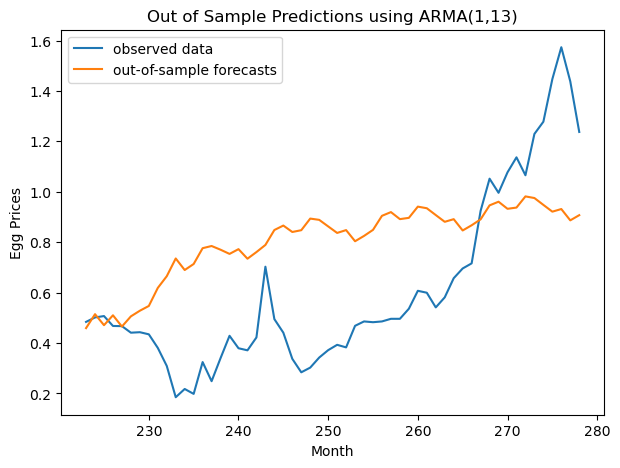

In [71]:
forecasts_1_13 = model_1_13.forecast(steps = len(data_test)) + pd.Series([seasonality_4[t % 12] for t in data_test['Month']], index = data_test.index) + data_test['Month'] * lr_log.coef_[0] + lr_log.intercept_
plt.figure(figsize=(7, 5))
plt.plot(data_test['log'], label='observed data')
plt.plot(forecasts_1_13, label='out-of-sample forecasts')
plt.xlabel('Month')
plt.ylabel('Egg Prices')
plt.title('Out of Sample Predictions using ARMA(1,13)')
_ = plt.legend()

In [72]:
round(mean_squared_error(data_test['log'], forecasts_1_13),5)

0.13001

### Values detrended using MA

In [74]:
def forecast_trend(initial_values, f_noise_and_seasonality):
  trend = list(initial_values)
  for i in range(len(f_noise_and_seasonality)):
    trend.append(sum(trend[i:i+4])/4)
  return trend[4:]

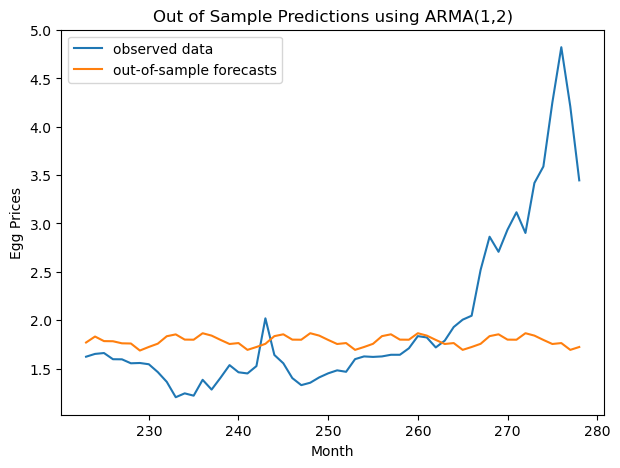

In [76]:
forecasts_1_2 = model_1_2.forecast(steps = len(data_test))
forecasts_1_2.index = data_test.index
forecasts_1_2 += pd.Series([seasonality_3[t % 12] for t in data_test['Month']], index = data_test.index) 
forecasts_1_2 += pd.Series(forecast_trend(data_train['Value'][len(data_train)-4:len(data_train)], forecasts_1_2), index = data_test.index)

plt.figure(figsize=(7, 5))
plt.plot(data_test['Value'], label='observed data')
plt.plot(forecasts_1_2, label='out-of-sample forecasts')
plt.xlabel('Month')
plt.ylabel('Egg Prices')
plt.title('Out of Sample Predictions using ARMA(1,2)')
_ = plt.legend()

In [77]:
round(mean_squared_error(data_test['Value'], forecasts_1_2), 5)

0.73798

---
# Conclusions

- We see that the model is not doing the best job at predicting the values, this is because if we go back to look at the data. (Separation of the train and test data), we see that the test data was actually not cohesive with trend that the data followed until the sliced segment.
- Therefore, we see in the out of sample prediction that the prediction is not as well as it could have been. This discrepancy can also be attributed to the fact that we do not have a lot of variation in our input data.

However, we do see that the mean squared error in case of Log values is significantly lesser than in case of normal values. That is because we are comparing two different sets of data, the original and one that has been scaled (Log values). Therefore, we can't compare using the MSE because they are of different magnitudes

We can also see that, although the MSE for the model that was trained using data detrended using MA is higher, we can see that it is because the forecasted values before the pandemic are much closer to the real values. With the sudden spike in prices when the pandemic hit, the difference between forecasted values and real values was so high that the MSE squared those differences.